In [1]:
import os
import matplotlib.pyplot as plt
from features_reindex import get_feature, read_data
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import KFold, GridSearchCV
from rdkit.ML.Scoring.Scoring import CalcBEDROC
# from pseudo_label import select_pseudo_negatives
from pseudo_reindex import select_pseudo_negatives
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer


# def select_parameter(X_train,y_train):
#         # Define parameter grid
#     param_grid = {
#         'C': [0.1, 0.5, 0.8, 1, 10],
#         'kernel': ['rbf'],
#         'gamma': ['scale', 'auto',0.1,1,10,100]
#     }

#     # Initialize SVM with probability estimates
#     clf = svm.SVC(probability=True)
#     # Perform Grid Search with Cross-Validation using AUC as the scoring metric
#     grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
#     grid_search.fit(X_train,y_train)
#     return grid_search.best_params_
#     # print("Best cross-validation AUC:", grid_search.best_score_)

# Define the custom scoring function
def custom_score(y_true, y_proba):
    scores = np.column_stack((y_true, y_proba))  
    scores = scores[scores[:, 1].argsort()[::-1]] 
    return CalcBEDROC(scores, col=0, alpha=160.9)  

# Wrap the custom_score function using make_scorer
custom_scorer = make_scorer(custom_score, response_method='predict_proba')

def select_parameter(X_train, y_train, metric):
    # Define parameter grid
    param_grid = {
        'C': [0.1, 0.5, 0.8, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 1, 10, 100]
    }
    
    # Initialize SVM with probability estimates
    clf = svm.SVC(probability=True)
    
    if metric == 'bedroc_1':
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=custom_scorer, verbose=1)
    elif metric == 'auroc':
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
    grid_search.fit(X_train, y_train)
    # print(metric,grid_search.best_params_, grid_search.best_score_)
    return grid_search.best_params_

def average_rank_ratio(y_scores, y_test):
    """
    Calculate the average predicted rank of true positives.

    Parameters:
    y_scores (array-like): Decision function scores from the classifier.
    y_test (array-like): True binary labels (0 for negative, 1 for positive).

    Returns:
    float: The average rank of true positives.
    """
    
    # Convert inputs to numpy arrays for consistency
    y_scores = np.array(y_scores)
    y_test = np.array(y_test)

    # Step 1: Sort scores in descending order and assign ranks
    sorted_indices = np.argsort(-y_scores)  # Negative for descending sort
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(y_scores) + 1)  # Rank starts from 1

    # Step 2: Identify true positives
    true_positive_indices = np.where(y_test == 1)[0]

    # Step 3: Extract ranks of true positives
    true_positive_ranks = ranks[true_positive_indices]

    # Step 4: Calculate the average rank of true positives
    average_rank = np.mean(true_positive_ranks)

    rank_ratio = average_rank/y_test.shape[0]

    return round(rank_ratio,4)

def top_recall_precision(frac,y_scores,y_test):
    if np.sum(y_test==1) == 0:
        return 0,0,0
    else:
        cut = int(len(y_scores)*frac)
        top_30_indices = np.argsort(y_scores)[-cut:][::-1]
        top_30_y_scores = y_scores[top_30_indices]
        top_30_y_test = y_test[top_30_indices]

        TP = np.sum(top_30_y_test == 1)

        recall = TP/np.sum(y_test==1)
        precision = TP/len(top_30_indices)
        max_precision = np.sum(y_test==1)/len(top_30_indices)

    return recall, precision, max_precision

def eval_assemble(y_test,y_scores):
    
    rank_ratio = average_rank_ratio(y_scores, y_test)
        
    ############### AUCROC
    if y_scores is not None:
        try:
            auroc = roc_auc_score(y_test, y_scores)
        except:
            auroc = "AUROC computation failed (possibly due to label issues)"
    else:
        auroc = "AUROC not available (no predict_proba or decision_function)"


    ############### BEDROC
    scores = np.column_stack((y_test, y_scores))  # Stack labels and scores as columns
    scores = scores[scores[:, 1].argsort()[::-1]]  # Sort by scores in descending order
    ############# top recall percentage
    top_recall_10, top_precision_10, max_precision_10 = top_recall_precision(0.1,y_scores,y_test)
    top_recall_30, top_precision_30, max_precision_30 = top_recall_precision(0.3,y_scores,y_test)
    ############### top recall
    total_positives = np.sum(y_test)
    top_25_positives = np.sum(scores[:25, 0])
    top_300_positives = np.sum(scores[:300, 0])
    
    top_25_recall = top_25_positives / total_positives if total_positives > 0 else 0
    top_300_recall = top_300_positives / total_positives if total_positives > 0 else 0
    return (
        # recall_score(y_test, y_pred, average="binary", pos_label=1), 
        # precision_score(y_test, y_pred, average="binary", pos_label=1), 
        # f1_score(y_test, y_pred, average="binary", pos_label=1),
        top_25_recall,
        top_300_recall,
        top_recall_10, top_precision_10, max_precision_10,
        top_recall_30, top_precision_30, max_precision_30,
        auroc,
        rank_ratio,
        CalcBEDROC(scores, col=0, alpha=160.9),
        CalcBEDROC(scores, col=0, alpha=32.2),
        CalcBEDROC(scores, col=0, alpha=16.1),
        CalcBEDROC(scores, col=0, alpha=5.3)
    )


def calculate_er_n(scores, y_test, n):
    """
    Calculate ER_n where the top n predictions are considered positive.
    ER_n = TPR/(TPR+FPR)
    
    Parameters:
    scores - sorted array of [label, score] pairs, highest scores first
    y_test - original labels
    n - number of top predictions to consider
    
    Returns:
    er_n - the ER_n metric value
    """
    # Ensure n doesn't exceed available data
    n = min(n, len(scores))
    
    # Count true positives in top n
    top_n_labels = scores[:n, 0]
    tp_n = np.sum(top_n_labels)
    
    # Calculate TPR and FPR for top n
    total_positives = np.sum(y_test)
    total_negatives = len(y_test) - total_positives
    
    tpr_n = tp_n / total_positives if total_positives > 0 else 0
    fpr_n = (n - tp_n) / total_negatives if total_negatives > 0 else 0
    
    # Calculate ER_n
    er_n = tpr_n / (tpr_n + fpr_n) if (tpr_n + fpr_n) > 0 else 0
    
    return er_n

def get_ranks_numpy(arr):
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-arr)
    
    # Create array to store ranks
    ranks = np.zeros_like(arr, dtype=int)
    
    # Assign ranks
    for rank, idx in enumerate(sorted_indices):
        ranks[idx] = rank
    
    return ranks

def eval(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)
    y_test[y_test == -1] = 0
    if hasattr(clf, "decision_function"):
        y_scores = clf.decision_function(X_test)
    elif hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    else:
        y_scores = None  # AUROC cannot be computed without scores

    rank_ratio = average_rank_ratio(y_scores, y_test)
    
    # if -1 in y_test:
    #     y_test = np.where(y_test == -1, 0, y_test)
    # if -1 in y_pred:
    #     y_pred = np.where(y_pred == -1, 0, y_pred)
        
    ############### AUCROC
    if y_scores is not None:
        try:
            auroc = roc_auc_score(y_test, y_scores)
        except:
            auroc = "AUROC computation failed (possibly due to label issues)"
    else:
        auroc = "AUROC not available (no predict_proba or decision_function)"

    
    ############### BEDROC
    scores = np.column_stack((y_test, y_scores))  # Stack labels and scores as columns
    scores = scores[scores[:, 1].argsort()[::-1]]  # Sort by scores in descending order
    ############# top recall
    top_recall_10, top_precision_10, max_precision_10 = top_recall_precision(0.1,y_scores,y_test)
    top_recall_30, top_precision_30, max_precision_30 = top_recall_precision(0.3,y_scores,y_test)
    ############### top recall
    total_positives = np.sum(y_test)
    top_25_positives = np.sum(scores[:25, 0])
    top_300_positives = np.sum(scores[:300, 0])
    
    top_25_recall = top_25_positives / total_positives if total_positives > 0 else 0
    top_300_recall = top_300_positives / total_positives if total_positives > 0 else 0
    return get_ranks_numpy(y_scores),(
        # recall_score(y_test, y_pred, average="binary", pos_label=1), 
        # precision_score(y_test, y_pred, average="binary", pos_label=1), 
        # f1_score(y_test, y_pred, average="binary", pos_label=1),
        top_25_recall,
        top_300_recall,
        top_recall_10, top_precision_10, max_precision_10,
        top_recall_30, top_precision_30, max_precision_30,
        calculate_er_n(scores, y_test, 100),
        calculate_er_n(scores, y_test, 1000),
        calculate_er_n(scores, y_test, int(0.1*len(y_test))),
        calculate_er_n(scores, y_test, int(0.3*len(y_test))),
        auroc,
        rank_ratio,
        CalcBEDROC(scores, col=0, alpha=160.9),
        CalcBEDROC(scores, col=0, alpha=32.2),
        CalcBEDROC(scores, col=0, alpha=16.1),
        CalcBEDROC(scores, col=0, alpha=5.3)
    )



In [2]:
all_df = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/timecut/disgent_with_time.csv')

selected_diseases = (
    all_df.groupby('disease_id')
    .filter(lambda x: (len(x) > 15))
    ['disease_id']
    .unique()
    .tolist())

In [5]:
import pickle
import gseapy as gp
with open('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb/2023/name_convert.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
stringId2name,name2stringId,aliases2stringId = loaded_data

def string_convert(gene):
    if gene in name2stringId.keys():
        return name2stringId[gene]
    elif gene in aliases2stringId.keys():
        return aliases2stringId[gene]
    else:
        return None

def mask_enrich(df,train_pos):
    enr = gp.enrichr(gene_list=train_pos.map(stringId2name).tolist(),
                    gene_sets=['KEGG_2021_Human'],
                    organism='human', 
                    outdir=None, 
                    )
    enr_df = enr.results
    gene_lists = enr_df[enr_df['Adjusted P-value']<0.01]['Genes'].to_list()
    mask_gene_pool = set()
    for items in gene_lists:
        genes = items.split(';')
        mask_gene_pool.update(set(genes))
    mask_index = df[df.index.isin([string_convert(gene) for gene in list(mask_gene_pool)])].index
    return mask_index

def mask_ppi_loop(df,train_pos, threshold):
    ppi_connection = pd.read_csv(os.path.join('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb/2023','9606.protein.links.v12.0.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
    ppi_connection_med = ppi_connection[ppi_connection['combined_score']>threshold]
    first_loop_genes = set(ppi_connection_med[ppi_connection_med['protein1'].isin(list(train_pos))]['protein2'].tolist())
    mask_index = df[df.index.isin(first_loop_genes)].index
    return mask_index

In [7]:
for disease in selected_diseases:
    feature_df = get_feature('/itf-fi-ml/shared/users/ziyuzh/svm','ppi')
    df, y = read_data(disease, all_df, feature_df)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    pos_df = df[y == 1]
    neg_df = df[y == 0]

    fold = 0
    train_id, test_id = next(kf.split(pos_df))

    train_idx = df[y == 1].index[train_id]
    test_idx = df[y == 1].index[test_id]

    train_pos_df = df.loc[train_idx]
    test_pos_df = df.loc[test_idx]
    neg_num = 5*len(train_pos_df)

    neg_df = df[y == 0]
    X_neg = neg_df.values
    y_neg = np.zeros(len(neg_df))
    neg_indices = neg_df.index.values

    # Get positive training samples
    X_train_pos_np = train_pos_df.values
    y_train_pos_np = np.ones(len(train_pos_df))

    mask_ids = mask_enrich(df,train_pos_df.index).tolist()
    mask_ids.extend(mask_ppi_loop(df,train_pos_df.index, 900).tolist())
    print(disease, len(train_idx),len(mask_ids))

ICD10_C16 75 1746
ICD10_C18 39 919
ICD10_C43 40 1147
ICD10_C45 34 967
ICD10_C50 463 4243
ICD10_C54 20 742
ICD10_C56 99 1918
ICD10_C61 448 3741
ICD10_C67 156 2649
ICD10_C81 18 771
ICD10_C82 16 570
ICD10_C92 23 541
ICD10_D46 13 345
ICD10_D57 16 411
ICD10_D83 21 380
ICD10_D86 16 228
ICD10_E10 89 1197
ICD10_E11 230 2704
ICD10_E66 221 2536
ICD10_E84 37 717
ICD10_F01 32 607
ICD10_F20 726 5208
ICD10_F31 374 3552
ICD10_F72 26 402
ICD10_F90 20 279
ICD10_G10 28 578
ICD10_G20 116 1943
ICD10_G24 24 436
ICD10_G30 158 2392
ICD10_G35 95 1238
ICD10_G40 102 1048
ICD10_G41 52 938
ICD10_G43 21 395
ICD10_G91 18 210
ICD10_H40 17 409
ICD10_I10 28 537
ICD10_I25 115 1543
ICD10_I26 12 141
ICD10_I42 134 1830
ICD10_I46 16 367
ICD10_I50 128 2254
ICD10_I61 22 470
ICD10_I63 31 543
ICD10_I70 55 829
ICD10_I95 44 722
ICD10_J45 163 1893
ICD10_J62 12 307
ICD10_J80 40 633
ICD10_K25 14 310
ICD10_K44 51 805
ICD10_K51 60 905
ICD10_L20 48 754
ICD10_L23 56 654
ICD10_L40 63 976
ICD10_L63 12 212
ICD10_L80 30 703
ICD10_M16 14 10

In [146]:
scores = np.column_stack((np.array([0,0,1,1]), np.array([0.3,0.5,0.7,0.6])))  # Stack labels and scores as columns
scores[scores[:, 1].argsort()[::-1]] 

array([[1. , 0.7],
       [1. , 0.6],
       [0. , 0.5],
       [0. , 0.3]])

In [147]:
np.argsort(np.array([0.3,0.5,0.7,0.6]))[-2:][::-1]

array([2, 3])

In [149]:
#### string gene_id map
local_stringdb = os.path.join('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb','2023')

ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.info.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
ppidf['preferred_name'] = ppidf['preferred_name'].str.upper()
stringId2name = ppidf.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = ppidf.set_index('preferred_name')['#string_protein_id'].to_dict()


In [2]:
root = '/itf-fi-ml/shared/users/ziyuzh/svm'
feature = 'ppi'


out_path = os.path.join(root,'results/temp')
if not os.path.exists(out_path):
    os.mkdir(out_path)

feature_df = get_feature(root,feature)

all_df = pd.read_csv(os.path.join(root,'data','disgent_2020','disgenet_string.csv'))

disease = 'ICD10_I25'
# disease = 'ICD10_C43'
# disease = 'ICD10_C16'

df, y = read_data(disease, all_df, feature_df)

In [9]:
train_idx, test_idx = next(kf.split(df[y == 1].index))
df[y == 1].index[test_idx]

Index(['9606.ENSP00000454071', '9606.ENSP00000233242', '9606.ENSP00000356438',
       '9606.ENSP00000363089', '9606.ENSP00000331504', '9606.ENSP00000353452',
       '9606.ENSP00000272067', '9606.ENSP00000356015', '9606.ENSP00000385523',
       '9606.ENSP00000405330', '9606.ENSP00000301455', '9606.ENSP00000478645',
       '9606.ENSP00000308541', '9606.ENSP00000252486', '9606.ENSP00000289104',
       '9606.ENSP00000255030', '9606.ENSP00000331736', '9606.ENSP00000304895',
       '9606.ENSP00000236850', '9606.ENSP00000348069', '9606.ENSP00000368683',
       '9606.ENSP00000303634', '9606.ENSP00000261292', '9606.ENSP00000301466',
       '9606.ENSP00000370543', '9606.ENSP00000252809', '9606.ENSP00000365651',
       '9606.ENSP00000271332', '9606.ENSP00000262887', '9606.ENSP00000364731',
       '9606.ENSP00000376865', '9606.ENSP00000292301', '9606.ENSP00000365081',
       '9606.ENSP00000351052'],
      dtype='object', name='string_id')

In [12]:
pos_df.index[test_idx]

Index(['9606.ENSP00000454071', '9606.ENSP00000233242', '9606.ENSP00000356438',
       '9606.ENSP00000363089', '9606.ENSP00000331504', '9606.ENSP00000353452',
       '9606.ENSP00000272067', '9606.ENSP00000356015', '9606.ENSP00000385523',
       '9606.ENSP00000405330', '9606.ENSP00000301455', '9606.ENSP00000478645',
       '9606.ENSP00000308541', '9606.ENSP00000252486', '9606.ENSP00000289104',
       '9606.ENSP00000255030', '9606.ENSP00000331736', '9606.ENSP00000304895',
       '9606.ENSP00000236850', '9606.ENSP00000348069', '9606.ENSP00000368683',
       '9606.ENSP00000303634', '9606.ENSP00000261292', '9606.ENSP00000301466',
       '9606.ENSP00000370543', '9606.ENSP00000252809', '9606.ENSP00000365651',
       '9606.ENSP00000271332', '9606.ENSP00000262887', '9606.ENSP00000364731',
       '9606.ENSP00000376865', '9606.ENSP00000292301', '9606.ENSP00000365081',
       '9606.ENSP00000351052'],
      dtype='object', name='string_id')

In [11]:
train_idx, test_idx = next(kf.split(pos_df))
test_idx

array([  9,  12,  15,  16,  18,  19,  24,  29,  30,  31,  42,  51,  55,
        56,  60,  67,  75,  76,  78,  82,  85,  97, 100, 101, 104, 108,
       119, 131, 132, 135, 136, 140, 146, 162])

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

pos_df = df[y == 1]
neg_df = df[y == 0]

fold = 0
train_idx, test_idx = next(kf.split(pos_df))

train_pos_df = pos_df.iloc[train_idx]
test_pos_df = pos_df.iloc[test_idx]

neg_num = 5*len(train_pos_df)

In [4]:
test_idx

array([  9,  12,  15,  16,  18,  19,  24,  29,  30,  31,  42,  51,  55,
        56,  60,  67,  75,  76,  78,  82,  85,  97, 100, 101, 104, 108,
       119, 131, 132, 135, 136, 140, 146, 162])

In [152]:
############# OCC
neg_df = df[y == 0]

# Convert to numpy arrays for modeling but keep track of original indices
X_test_pos_np = test_pos_df.values
X_neg_np = neg_df.values
X_test = np.vstack((X_test_pos_np, X_neg_np))

# Create labels for evaluation
y_test = np.array([1] * len(test_pos_df) + [-1] * len(neg_df))

# Keep track of original indices for the test set
test_indices = np.concatenate([test_pos_df.index.values, neg_df.index.values])

param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'nu': [0.5, 0.8, 0.9]
}

# Use train_pos_df values for training
X_train_pos_np = train_pos_df.values
y_train_pos_np = np.ones(len(train_pos_df))

grid_search = GridSearchCV(svm.OneClassSVM(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pos_np)
best_svm = svm.OneClassSVM(**grid_search.best_params_)
ranked_predict_index, results = eval(best_svm, X_train_pos_np, y_train_pos_np, X_test, y_test)

# If you need to map predictions back to the original dataframe:
predictions = best_svm.predict(X_test)


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", lin

In [153]:
results

(0.08823529411764706,
 0.35294117647058826,
 0.5588235294117647,
 0.009748589020010261,
 0.017444843509492047,
 0.7647058823529411,
 0.004446724816145032,
 0.005814947836497349,
 0.9733515658873362,
 0.9082251890579779,
 0.8492478473823987,
 0.7187802833312019,
 0.8280796488003096,
 0.1725,
 0.20606416114580287,
 0.3597081640704815,
 0.43649973143695675,
 0.5910589319495314)

In [154]:
occ_ranked_predict_index = ranked_predict_index

In [155]:
def get_top_n_predictions(ranked_predict_index,n):
    genes = []
    sorted_indices = np.argsort(ranked_predict_index)
    top_10_indices = sorted_indices[:n]
    test_indices[top_10_indices]
    for value in test_indices[top_10_indices]:
        genes.append(stringId2name[value])
    return genes

In [156]:
print(get_top_n_predictions(occ_ranked_predict_index,10))

['GAPDH', 'INS', 'ACTB', 'AKT1', 'ALB', 'APOE', 'HSP90AA1', 'CTNNB1', 'MYC', 'PPARG']


In [174]:
ooc_pred = get_top_n_predictions(occ_ranked_predict_index,10)
true_test = [stringId2name[value] for value in test_pos_df.index.values]
print(set(ooc_pred)&set(true_test))

{'APOE'}


In [158]:
#### the position of y_test = 1
ranked_predict_index[np.where(y_test==1)],len(y_test)

(array([ 9907,    15,    26,    88,  5051,   626,   879,  1596,    50,
           18,  1383, 14691,   811,     5,  3354,   156,   424,   287,
          120,   161,   129,  5617,  4859,  6120, 12109,   757,  3718,
         9168,  3885,  9186,  3641,   296,  6702,  8452]),
 19490)

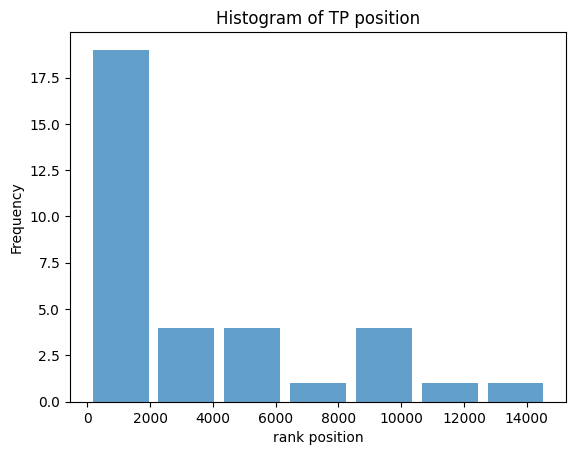

In [159]:
plt.hist(ranked_predict_index[np.where(y_test==1)], bins='auto', alpha=0.7, rwidth=0.85)

# Adding titles and labels
plt.title('Histogram of TP position')
plt.xlabel('rank position')
plt.ylabel('Frequency')

# Display plot
plt.show()

In [160]:

neg_df = df[y == 0]

# Randomly select 'neg_num' samples from negative class
train_neg_df = neg_df.sample(n=neg_num, random_state=42)

# Get the remaining negative samples
test_neg_df = neg_df.drop(train_neg_df.index)

# Combine positive and negative samples for training
train_df = pd.concat([train_pos_df, train_neg_df])
X_train = train_df.values
y_train = np.array([1] * len(train_pos_df) + [0] * len(train_neg_df))

# Store original indices for training set
train_indices = train_df.index.values

# Combine positive and negative samples for testing
test_df = pd.concat([test_pos_df, test_neg_df])
X_test = test_df.values
y_test = np.array([1] * len(test_pos_df) + [0] * len(test_neg_df))

# Store original indices for test set
test_indices = test_df.index.values

for metric in ['auroc']:
    # Select parameters and train the model
    parameters = select_parameter(X_train, y_train, metric)
    best_svm = svm.SVC(**parameters)
    ranked_predict_index, results = eval(best_svm, X_train, y_train, X_test, y_test)
    
    rn_ranked_predict_index = ranked_predict_index




Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [161]:
results

(0.11764705882352941,
 0.5294117647058824,
 0.8235294117647058,
 0.01486988847583643,
 0.018056293149229952,
 0.9411764705882353,
 0.005664719419366259,
 0.0060187643830766505,
 0.9855755021879856,
 0.9365365303979211,
 0.8929852483549897,
 0.7590030916777084,
 0.932748519710076,
 0.0681,
 0.3552669930789712,
 0.5627348112844017,
 0.6696526003554003,
 0.8140477798137556)

In [162]:
print(get_top_n_predictions(rn_ranked_predict_index,10))

['CETP', 'REN', 'RETNLB', 'CRP', 'APOE', 'CYP3A4', 'ANGPTL3', 'APOB', 'SELE', 'SCARB1']


In [173]:
rn_pred = get_top_n_predictions(rn_ranked_predict_index,10)
print(set(rn_pred)&set(true_test))

{'SELE', 'APOE', 'APOB', 'CRP'}


In [164]:
#### the position of y_test = 1
rn_ranked_predict_index[np.where(y_test==1)],len(y_test)

(array([  957,     7,    71,   265, 12723,   384,  2042,  2682,    36,
          153,    25,  4207,   100,     4,  2074,     3,     8,   146,
           34,   225,    33,   998,    32,   742, 10373,   517,   124,
          542,  1131,   819,  1099,    98,   737,   148]),
 18830)

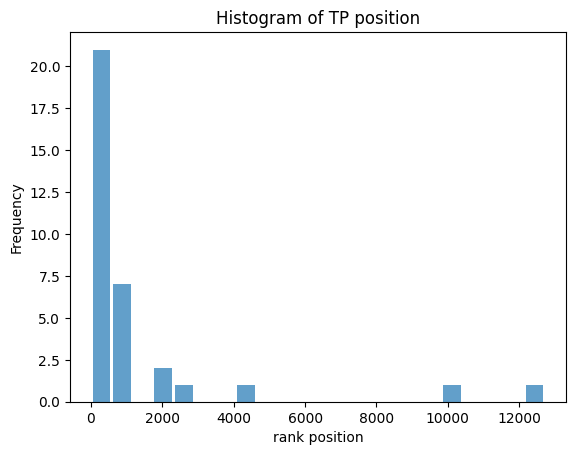

In [165]:
plt.hist(rn_ranked_predict_index[np.where(y_test==1)], bins='auto', alpha=0.7, rwidth=0.85)

# Adding titles and labels
plt.title('Histogram of TP position')
plt.xlabel('rank position')
plt.ylabel('Frequency')

# Display plot
plt.show()

In [ ]:

neg_df = df[y == 0]
X_neg = neg_df.values
y_neg = np.zeros(len(neg_df))
neg_indices = neg_df.index.values

# Get positive training samples
X_train_pos_np = train_pos_df.values
y_train_pos_np = np.ones(len(train_pos_df))

for func in [1]:
    # Use the modified function that returns indices
    all_sampled_combined_indices, neg_relative_indices, X_train_neg, y_train_neg = select_pseudo_negatives(
        neg_num, X_train_pos_np, y_train_pos_np, X_neg, y_neg, func, neg_indices
    )
    
    # Get original indices of selected negative samples
    selected_neg_original_indices = neg_indices[neg_relative_indices]
    
    # Create test set - get indices of negative samples not used in training
    test_neg_indices = np.setdiff1d(neg_indices, selected_neg_original_indices)
    X_test_neg = neg_df.loc[test_neg_indices].values
    
    # Create training set
    X_train = np.vstack((X_train_pos_np, X_train_neg))
    y_train = np.hstack((y_train_pos_np, y_train_neg))
    
    # Store original indices for training and test sets
    train_indices = np.concatenate([train_pos_df.index.values, selected_neg_original_indices])
    test_indices = np.concatenate([test_pos_df.index.values, test_neg_indices])
    
    # Create test set
    X_test_pos_np = test_pos_df.values
    X_test = np.vstack((X_test_pos_np, X_test_neg))
    y_test = np.array([1] * len(X_test_pos_np) + [0] * len(X_test_neg))
    
    for metric in ['auroc']:
        parameters = select_parameter(X_train, y_train, metric)
        best_svm = svm.SVC(**parameters)
        ranked_predict_index, results = eval(best_svm, X_train, y_train, X_test, y_test)
        pseudo_ranked_predict_index = ranked_predict_index
        

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [167]:
results

(0.23529411764705882,
 0.5,
 0.8235294117647058,
 0.01486988847583643,
 0.018056293149229952,
 0.9117647058823529,
 0.005487696937511064,
 0.0060187643830766505,
 0.9880403667944302,
 0.9286512075468456,
 0.8929954157858483,
 0.753134733441034,
 0.9350087305908639,
 0.0658,
 0.37942637900494763,
 0.5485492952848462,
 0.649504839604776,
 0.8015652665215898)

In [168]:
print(get_top_n_predictions(pseudo_ranked_predict_index,10))

['PPP3CA', 'CREB1', 'ZNF665', 'APOB', 'APOE', 'UGT1A4', 'CRP', 'SPACA1', 'CTSK', 'TMEM256']


In [172]:
pseudo_pred = get_top_n_predictions(pseudo_ranked_predict_index,10)
print(set(pseudo_pred)&set(true_test))

{'APOE', 'APOB', 'CRP'}


In [170]:
#### the position of y_test = 1
pseudo_ranked_predict_index[np.where(y_test==1)],len(y_test)

(array([ 1299,     3,    24,   127, 11709,   335,  1443,  2788,    12,
          250,    23,  2533,   706,     4,  2186,     6,    35,    84,
           13,    53,    16,   569,    70,  1245,  5690,   245,   336,
          995,   881,  6100,  1080,    48,  1035,   156]),
 18832)

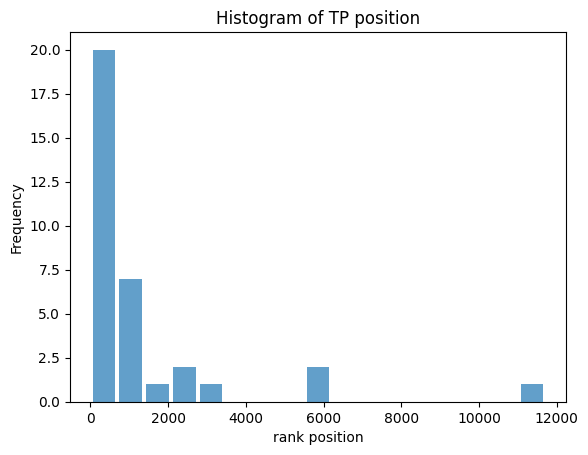

In [171]:
plt.hist(pseudo_ranked_predict_index[np.where(y_test==1)], bins='auto', alpha=0.7, rwidth=0.85)

# Adding titles and labels
plt.title('Histogram of TP position')
plt.xlabel('rank position')
plt.ylabel('Frequency')

# Display plot
plt.show()

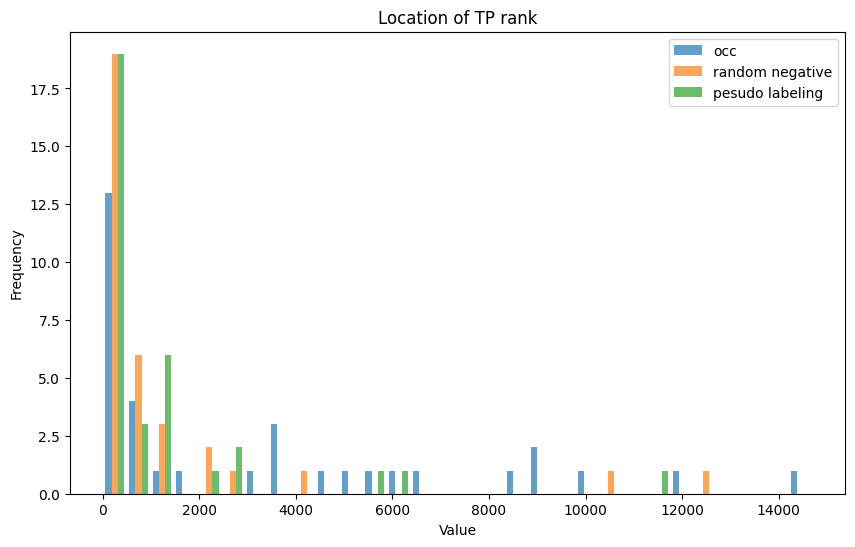

In [177]:
data = [occ_ranked_predict_index[np.where(y_test==1)],rn_ranked_predict_index[np.where(y_test==1)],pseudo_ranked_predict_index[np.where(y_test==1)]]
# Define the number of bins
bins = 30

# Plot the multi histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, label=['occ', 'random negative', 'pesudo labeling'], alpha=0.7)

# Add legend, labels, and title
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Location of TP rank')

# Display the plot
plt.show()

In [192]:
rn_500 = get_top_n_predictions(rn_ranked_predict_index,int(0.01*len(rn_ranked_predict_index)))
occ_500 = get_top_n_predictions(occ_ranked_predict_index,int(0.01*len(occ_ranked_predict_index)))
pseudo_500 = get_top_n_predictions(pseudo_ranked_predict_index,int(0.01*len(pseudo_ranked_predict_index)))

In [195]:
rn_fp = [item for item in rn_500 if item not in true_test]
occ_fp = [item for item in occ_500 if item not in true_test]
pseudo_fp = [item for item in pseudo_500 if item not in true_test]

In [181]:
import gseapy as gp

In [182]:
year = '2023'
annotations = ['GO_Biological_Process_'+year,'GO_Cellular_Component_'+year,'GO_Molecular_Function_'+year]

In [187]:
enr = gp.enrichr(gene_list=true_test, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
# enr.results.sort_values(by='Combined Score',ascending=False)
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cholesterol metabolism,7/50,2.012254e-12,2.595807e-10,0,0,120.121447,3235.082675,SOAT2;LIPG;APOA1;ANGPTL4;APOE;APOB;LDLR
1,KEGG_2021_Human,Lipid and atherosclerosis,5/215,2.957716e-05,1.907727e-03,0,0,16.220033,169.150743,APOA1;APOB;SELE;TLR4;LDLR
2,KEGG_2021_Human,Fat digestion and absorption,3/43,5.287537e-05,2.273641e-03,0,0,48.208065,474.732434,APOA1;APOB;ACAT2
3,KEGG_2021_Human,PPAR signaling pathway,3/74,2.679265e-04,8.640629e-03,0,0,27.117219,223.033649,APOA1;ANGPTL4;PPARA
4,KEGG_2021_Human,Regulation of actin cytoskeleton,4/218,4.927200e-04,1.271218e-02,0,0,12.306542,93.721326,MRAS;PDGFD;F2;MYLK
...,...,...,...,...,...,...,...,...,...,...
124,KEGG_2021_Human,Shigellosis,1/246,3.437032e-01,3.547017e-01,0,0,2.439208,2.605018,TLR4
125,KEGG_2021_Human,Salmonella infection,1/249,3.470863e-01,3.553502e-01,0,0,2.409335,2.549515,TLR4
126,KEGG_2021_Human,Endocytosis,1/252,3.504525e-01,3.559714e-01,0,0,2.380176,2.495687,LDLR
127,KEGG_2021_Human,Human papillomavirus infection,1/331,4.332743e-01,4.366592e-01,0,0,1.803122,1.508103,PTGS2


In [196]:
enr2 = gp.enrichr(gene_list=occ_fp, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
enr2.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Insulin signaling pathway,7/137,0.000280,0.043835,0,0,5.988787,48.991889,SHC3;RHEB;PDPK1;ARAF;TRIP10;PRKACA;PRKAB1
1,KEGG_2021_Human,Longevity regulating pathway,6/102,0.000362,0.043835,0,0,6.924157,54.860924,CREB3;RHEB;PRKACA;PRKAB1;SIRT1;SOD1
2,KEGG_2021_Human,Vasopressin-regulated water reabsorption,4/44,0.000706,0.047569,0,0,10.986667,79.716629,DCTN6;CREB3;AVP;PRKACA
3,KEGG_2021_Human,Vibrio cholerae infection,4/50,0.001148,0.047569,0,0,9.550725,64.658976,KDELR3;PRKACA;ATP6V0D1;ATP6V1F
4,KEGG_2021_Human,Human cytomegalovirus infection,8/225,0.001164,0.047569,0,0,4.105362,27.734866,CREB3;IL6;CXCL8;RHEB;E2F1;GNB4;PRKACA;B2M
...,...,...,...,...,...,...,...,...,...,...
237,KEGG_2021_Human,Hippo signaling pathway,1/163,0.779686,0.791213,0,0,0.662956,0.164986,WNT5B
238,KEGG_2021_Human,MicroRNAs in cancer,2/310,0.781404,0.791213,0,0,0.696018,0.171682,E2F1;SIRT1
239,KEGG_2021_Human,Herpes simplex virus 1 infection,3/498,0.840142,0.847143,0,0,0.646945,0.112687,IL6;RHEB;B2M
240,KEGG_2021_Human,Rap1 signaling pathway,1/210,0.857896,0.861455,0,0,0.512642,0.078574,RASGRP3


In [197]:
enr3 = gp.enrichr(gene_list=rn_fp, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
enr3.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cholesterol metabolism,16/50,1.678573e-21,3.474646e-19,0,0,59.710407,2856.327526,SCARB1;CETP;LRP1;APOA2;APOA4;LRP2;ABCB11;CYP7A...
1,KEGG_2021_Human,PPAR signaling pathway,15/74,6.577857e-17,6.524282e-15,0,0,32.012847,1192.806275,APOA2;UCP1;CYP7A1;CYP8B1;CYP27A1;FABP1;RXRA;FA...
2,KEGG_2021_Human,Rheumatoid arthritis,16/93,9.455481e-17,6.524282e-15,0,0,26.308358,970.708759,CSF2;CXCL8;FLT1;TGFB1;CSF1;ANGPT1;PTH;CXCL1;IC...
3,KEGG_2021_Human,Metabolism of xenobiotics by cytochrome P450,14/76,3.064217e-15,1.585732e-13,0,0,28.248673,944.041962,UGT1A10;CYP3A4;CYP3A5;CYP2C9;CYP2D6;CYP1A2;GST...
4,KEGG_2021_Human,Drug metabolism,15/108,2.455833e-14,1.016715e-12,0,0,20.274296,635.350329,UGT1A10;CYP2C19;CYP3A4;MPO;CYP3A5;CYP2C9;CYP2D...
...,...,...,...,...,...,...,...,...,...,...
202,KEGG_2021_Human,Signaling pathways regulating pluripotency of ...,1/143,7.104827e-01,7.244823e-01,0,0,0.810724,0.277114,IGF1
203,KEGG_2021_Human,mTOR signaling pathway,1/154,7.369103e-01,7.477472e-01,0,0,0.752016,0.229582,IGF1
204,KEGG_2021_Human,Protein processing in endoplasmic reticulum,1/171,7.731113e-01,7.806539e-01,0,0,0.676230,0.174016,NFE2L2
205,KEGG_2021_Human,Human papillomavirus infection,2/331,7.805859e-01,7.843752e-01,0,0,0.697264,0.172720,VWF;SPP1


In [198]:
enr4 = gp.enrichr(gene_list=pseudo_fp, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
enr4.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Glucagon signaling pathway,5/107,0.002388,0.328367,0,0,5.755427,34.748253,LDHC;PPP3CA;CREB1;SIK1B;SIRT1
1,KEGG_2021_Human,Metabolism of xenobiotics by cytochrome P450,4/76,0.004276,0.328367,0,0,6.494083,35.423869,CBR1;CYP2S1;GSTA1;UGT1A4
2,KEGG_2021_Human,Axon guidance,6/182,0.005104,0.328367,0,0,4.011500,21.171495,PPP3CA;ROCK2;CXCR4;EPHB2;SRGAP1;EPHB1
3,KEGG_2021_Human,Prion disease,7/273,0.009789,0.370066,0,0,3.100983,14.346576,PPP3CA;PSMC5;CREB1;NDUFA6;CSNK2B;NDUFAB1;C8A
4,KEGG_2021_Human,Fatty acid biosynthesis,2/18,0.010392,0.370066,0,0,14.481725,66.133866,OLAH;MCAT
...,...,...,...,...,...,...,...,...,...,...
188,KEGG_2021_Human,Epstein-Barr virus infection,1/202,0.828610,0.846146,0,0,0.567685,0.106728,PSMC5
189,KEGG_2021_Human,Rap1 signaling pathway,1/210,0.840233,0.853499,0,0,0.545733,0.094999,TLN1
190,KEGG_2021_Human,MAPK signaling pathway,1/294,0.923703,0.929187,0,0,0.387610,0.030763,PPP3CA
191,KEGG_2021_Human,Cytokine-cytokine receptor interaction,1/295,0.924373,0.929187,0,0,0.386272,0.030376,CXCR4


<Axes: xlabel='Combined Score'>

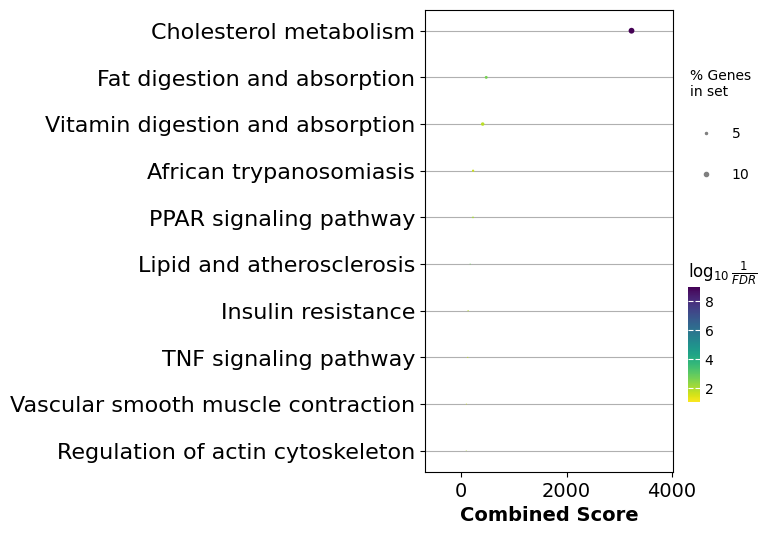

In [206]:
gp.dotplot(enr.res2d)

<Axes: xlabel='Combined Score'>

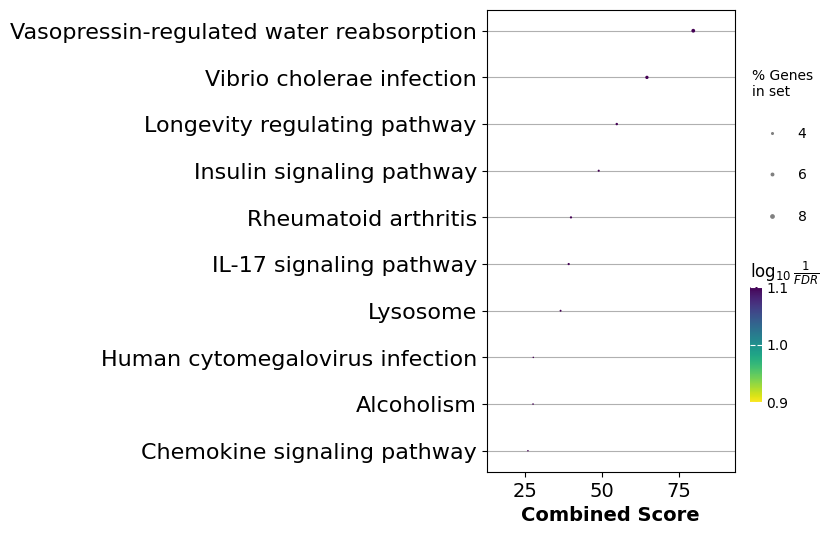

In [207]:
gp.dotplot(enr2.res2d)

<Axes: xlabel='Combined Score'>

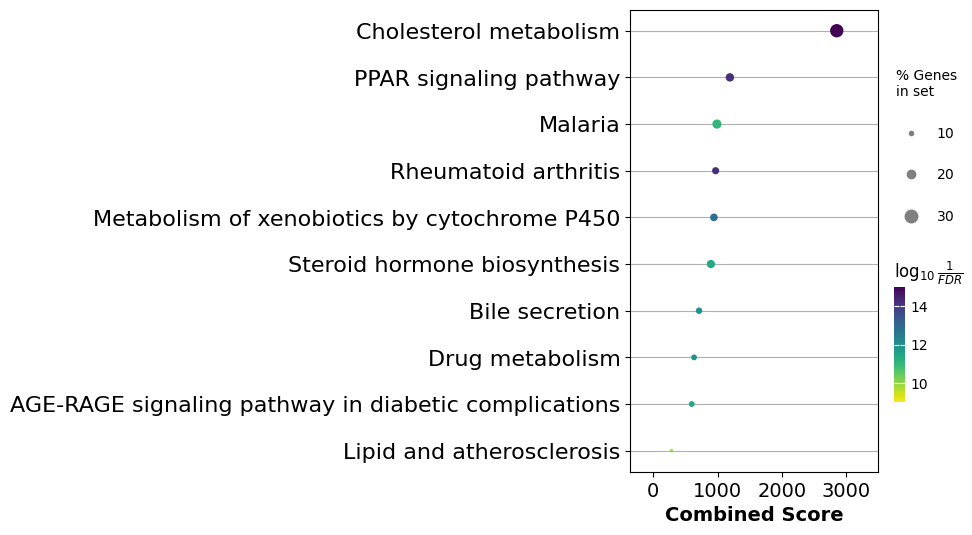

In [208]:
gp.dotplot(enr3.res2d)

In [209]:
gp.dotplot(enr4.res2d)

ValueError: Warning: No enrich terms when cutoff = 0.05